# Pointwise Reliability: Density, Clustering - DBSCAN

## Workflow:
- Perform grid search over `eps` and `min_samples` 
  - Select the parameters that maximize the number of clusters
- Train DBSCAN
- Workflow Reliability:
  - Determines whether the new instance is part of a cluster (eps distance to any core point in the cluster)
  - Identifies which cluster the new instance would belong to based on its nearest core point
  - Calculates the size of the identified cluster 
  - Compute reliability:
    - reliability=  cluster_size / `minimum_cluster_units`
      - `minimum_cluster_units` <- param 
      - If the cluster size is larger than the threshold (minimum cluster units): reliability = 1
      - If the new instance is not part of any cluster: reliability = 0

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from utils.reliability_visualizer import ReliabilityVisualizer

###########################################################
# Load Classifier and Training Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("dataset/data_train.csv")

# Map labels and preprocess training data
y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train = training_data.drop(columns=['SOURCE'])

# Preprocess training data using the loaded pipeline
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/correia/Documents/Projects/SI/pointwise-benchmark/.venv/lib/python3.12/site-packages/sklearn/base.py:380:

In [2]:
###########################################################
# Grid search DBSCAN Parameters
###########################################################

eps_values = np.linspace(0.01, 0.5, 10)
min_samples_values = range(2, 10, 2)

results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_train_preprocessed)
        
        labels = dbscan.labels_
        n_clusters = len(set(labels) - {-1})
        n_noise = list(labels).count(-1)
        
        if n_clusters > 0:
            cluster_sizes = [np.sum(labels == label) for label in set(labels) if label != -1]
            max_samples = max(cluster_sizes)
        else:
            max_samples = 0
        
        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "max_samples": max_samples
        })

results_df = pd.DataFrame(results)

best_params = results_df.loc[results_df['n_clusters'].idxmax()]
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']
best_max_samples = best_params['max_samples']

print("Best Parameters to Maximize Clusters:")
print(f"eps: {best_eps}")
print(f"min_samples: {best_min_samples}")
print(f"max_samples: {best_max_samples}")
# print(best_params)

Best Parameters to Maximize Clusters:
eps: 0.06444444444444444
min_samples: 2.0
max_samples: 233.0


In [3]:
###########################################################
# Train DBSCAN
###########################################################
eps_value = 0.06444444444444444
min_samples_value = 2

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan.fit(X_train_preprocessed)

core_samples_mask = dbscan.labels_ != -1  # Exclude noise (-1)
core_points = X_train_preprocessed[core_samples_mask]
core_labels = dbscan.labels_[core_samples_mask]

print(f"Number of clusters (excluding noise): {len(set(core_labels))}")
print(f"Number of core points: {len(core_points)}")

Number of clusters (excluding noise): 428
Number of core points: 1834


In [4]:
###########################################################
# Reliability Calculation with DBSCAN
###########################################################
def calculate_reliability_with_dbscan(new_instance, core_points, core_labels, dbscan, min_cluster_units):
    """
    Calculate reliability of a new instance based on DBSCAN clusters.

    Parameters:
    - new_instance: Preprocessed new instance.
    - core_points: Core points identified by DBSCAN.
    - core_labels: Cluster labels for core points.
    - dbscan (DBSCAN): Trained DBSCAN model on preprocessed training data.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - reliability_score: Reliability score based on cluster size.
    - in_cluster: Boolean indicating if the instance is part of a cluster.
    """
    # Find the nearest core point and its distance
    nbrs = NearestNeighbors(n_neighbors=1).fit(core_points)
    distance_to_core_point, nearest_core_idx = nbrs.kneighbors(new_instance.reshape(1, -1))
    nearest_core_idx = nearest_core_idx[0][0]  # Index of the nearest core point
    nearest_label = core_labels[nearest_core_idx]  # Cluster label of the nearest core point

    # Check if the new instance is in a cluster
    if nearest_label == -1 or distance_to_core_point[0][0] > dbscan.eps:
        return 0, False

    # Size of Cluster
    cluster_size = np.sum(core_labels == nearest_label)

    # Reliability
    reliability_score = min(cluster_size / min_cluster_units, 1.0)
    return reliability_score, True


def classify_and_check_reliability_dbscan(new_data, pipeline, core_points, core_labels, dbscan, min_cluster_units):
    """
    Predicts the class, determines cluster membership, and calculates reliability.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - core_points: Core points identified by DBSCAN.
    - core_labels: Cluster labels for core points.
    - dbscan: Trained DBSCAN model.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - dict: Contains prediction, cluster membership, and reliability score.
    """

    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)

    predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]

    # Calculate reliability
    reliability_score, in_cluster = calculate_reliability_with_dbscan(
        new_data_preprocessed[0], core_points, core_labels, dbscan, min_cluster_units
    )

    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score,
        "in_cluster": in_cluster
    }

In [5]:
###########################################################
# Load Validation Data and Test
###########################################################
validation_data = pd.read_csv("dataset/data_validation.csv")
validation_data['SOURCE'] = validation_data['SOURCE'].map({'out': 0, 'in': 1})
results = []

################
#### Adjust
min_cluster_units = 9  # Minimum points for full reliability

for _, instance in validation_data.iterrows():
    true_label = instance['SOURCE']
    instance_df = pd.DataFrame([instance.drop(labels=['SOURCE'])])
    result = classify_and_check_reliability_dbscan(
        instance_df, pipeline, core_points, core_labels, dbscan, min_cluster_units
    )
    result['true_label'] = true_label
    results.append(result)

# Filter results where reliability_score > 0
filtered_results = [result for result in results if result['reliability_score'] > 0]
# filtered_results

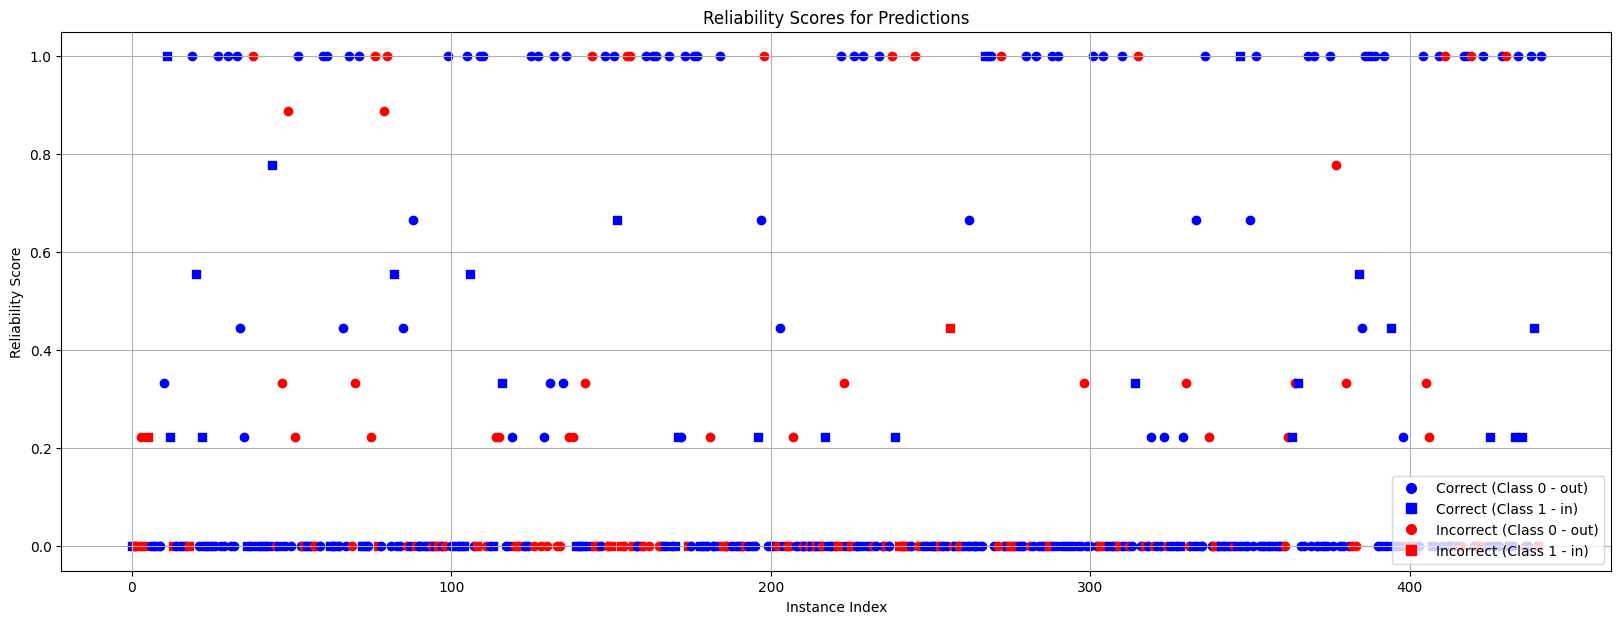

In [6]:
###########################################################
# Results and Visualization
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

In [7]:
reliability_table_df = visualizer.get_reliability_table_5()

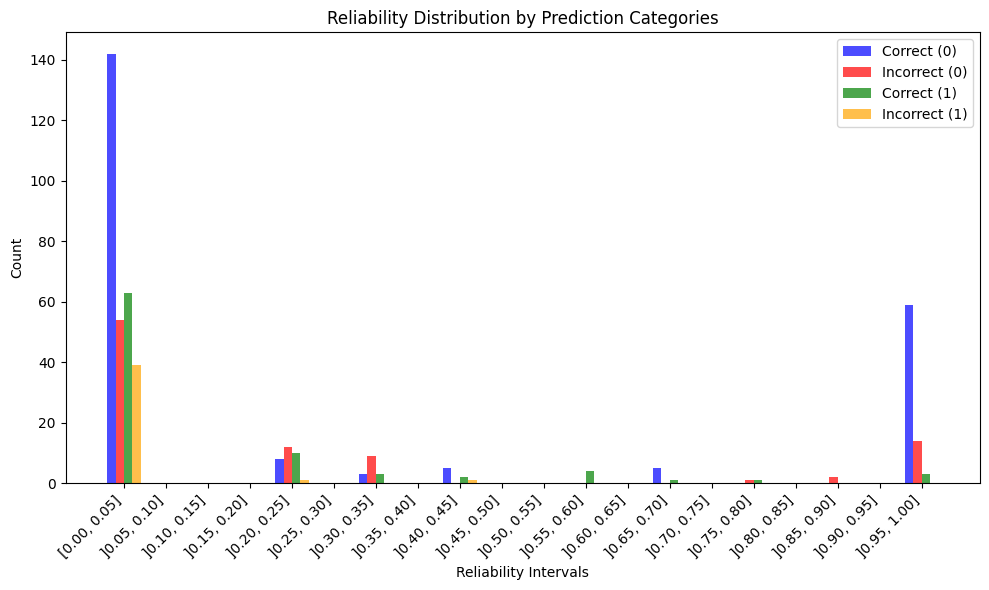

In [8]:
visualizer.plot_table_graph(reliability_table_df)

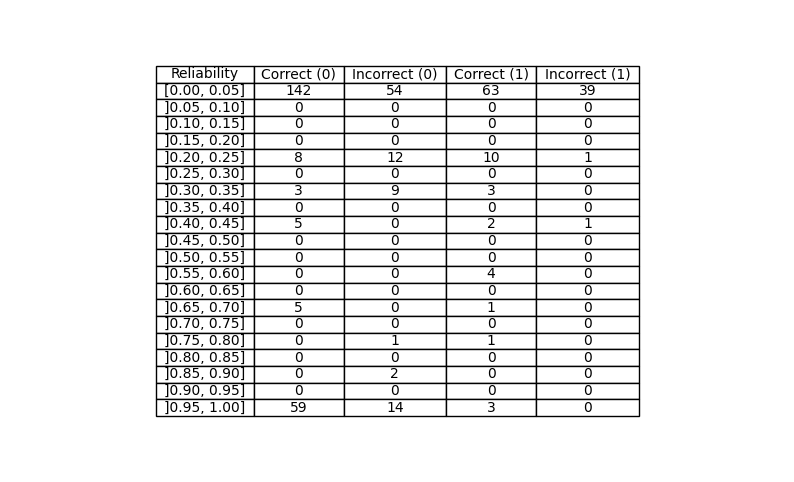

In [9]:
visualizer.plot_table_image(reliability_table_df)

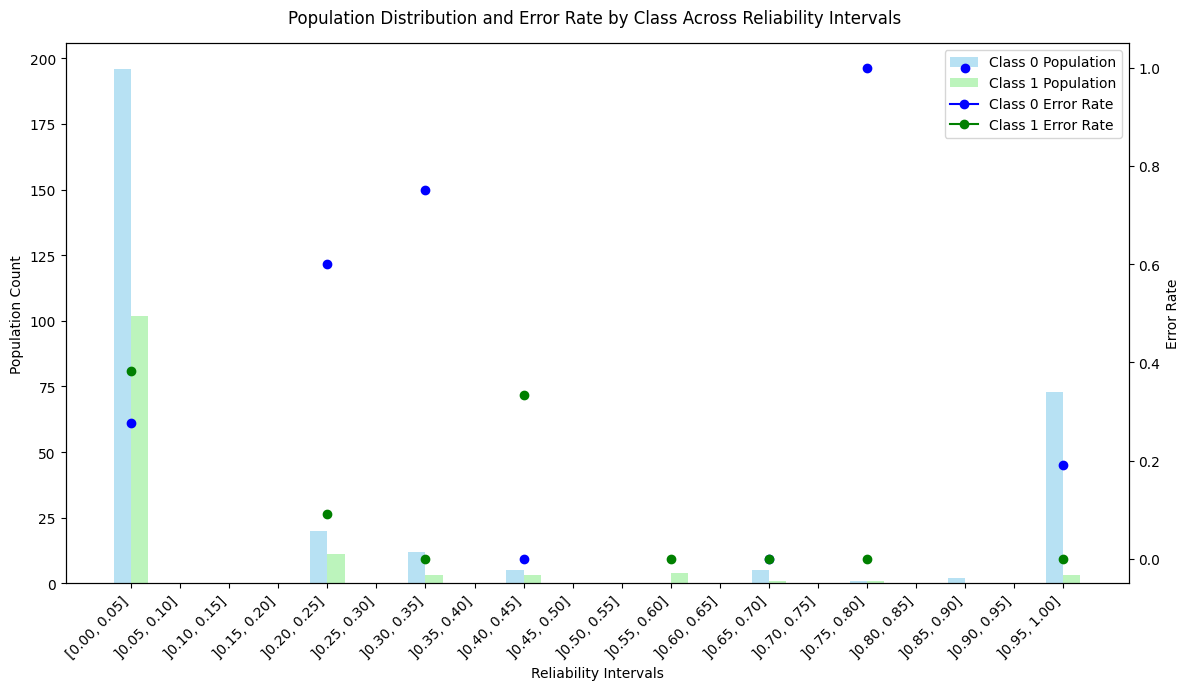

In [10]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [11]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]          142             54           63             39
1  ]0.10, 0.20]            0              0            0              0
2  ]0.20, 0.30]            8             12           10              1
3  ]0.30, 0.40]            3              9            3              0
4  ]0.40, 0.50]            5              0            2              1
5  ]0.50, 0.60]            0              0            4              0
6  ]0.60, 0.70]            5              0            1              0
7  ]0.70, 0.80]            0              1            1              0
8  ]0.80, 0.90]            0              2            0              0
9  ]0.90, 1.00]           59             14            3              0


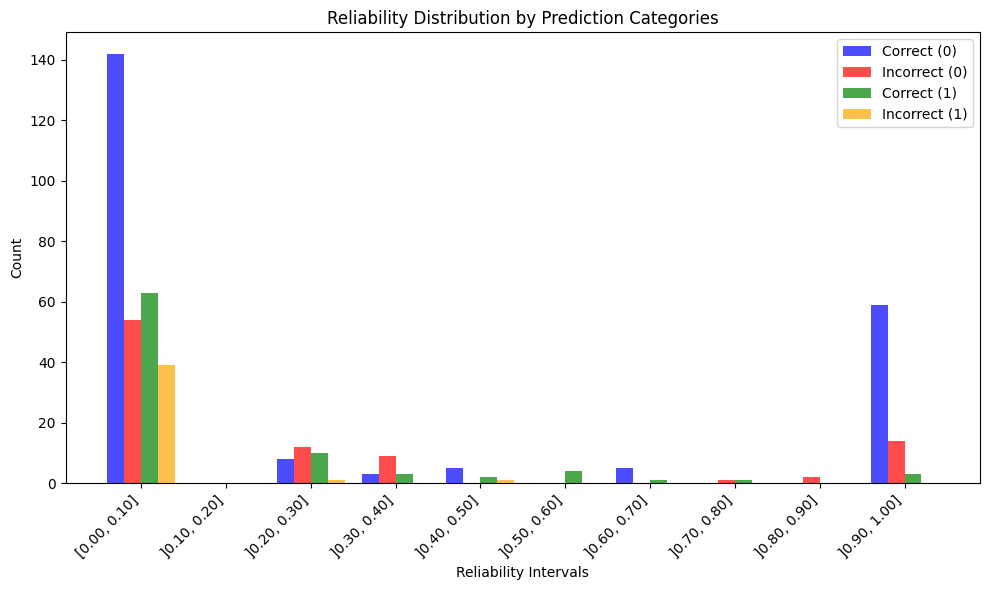

In [12]:
visualizer.plot_table_graph(reliability_table_10_df)

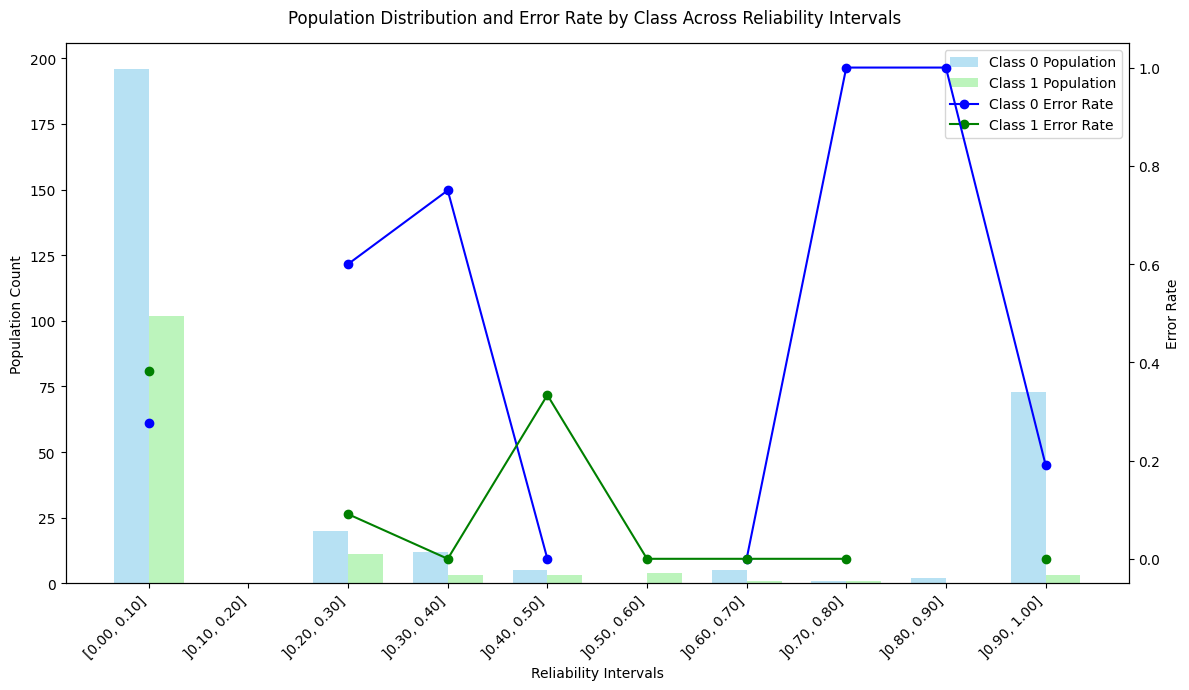

In [13]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           0.000000        (-0.001, 0.1]
1           0.000000        (-0.001, 0.1]
2           0.000000        (-0.001, 0.1]
3           0.222222           (0.2, 0.3]
4           0.000000        (-0.001, 0.1]
5           0.222222           (0.2, 0.3]
6           0.000000        (-0.001, 0.1]
7           0.000000        (-0.001, 0.1]
8           0.000000        (-0.001, 0.1]
9           0.000000        (-0.001, 0.1]


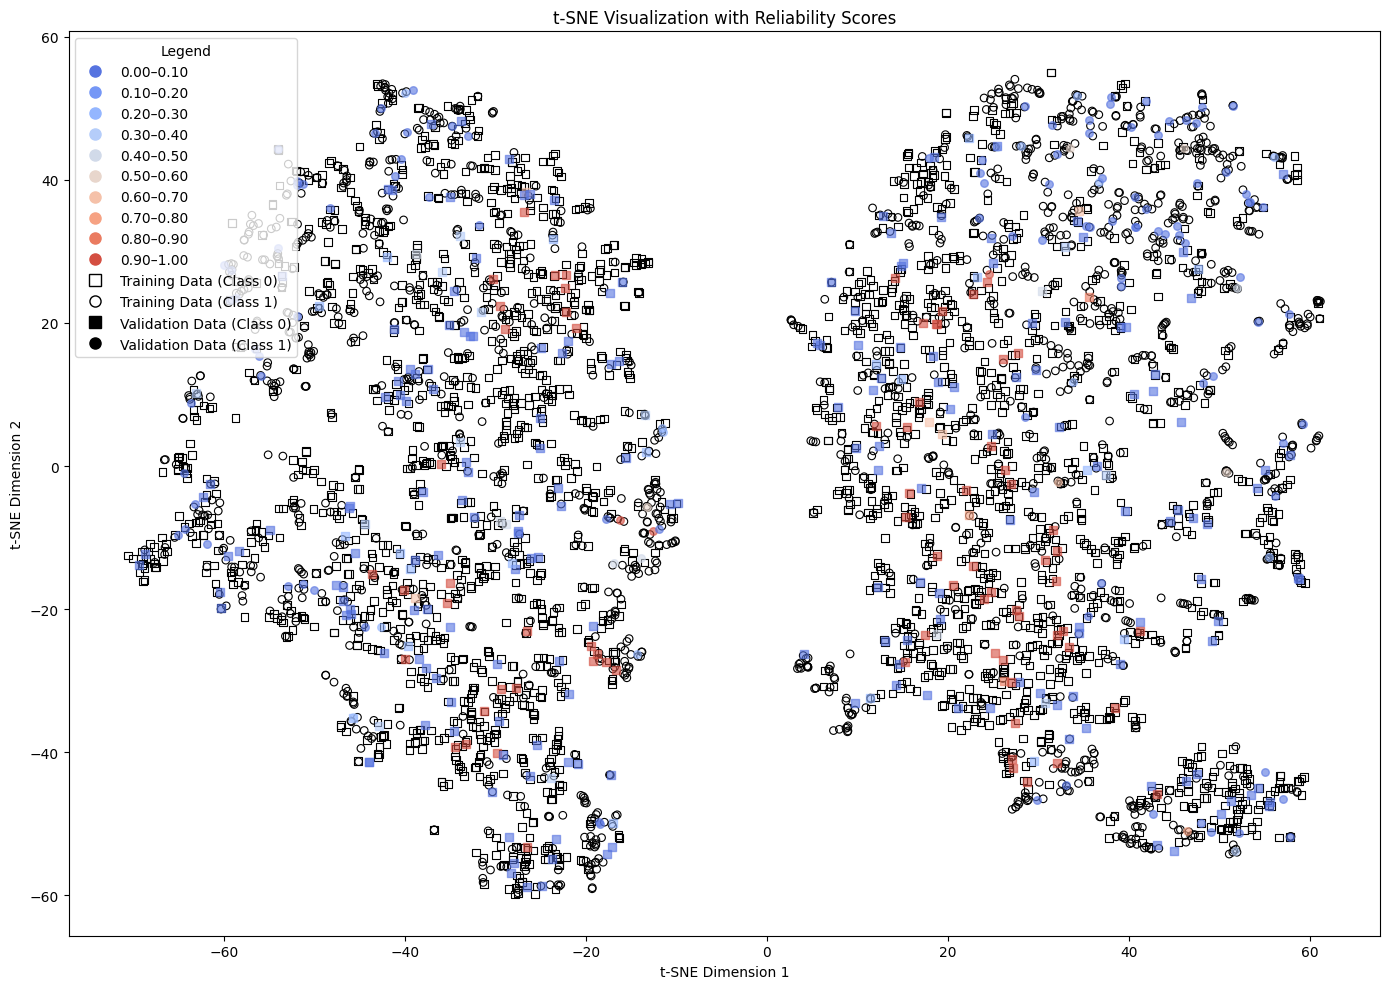

In [14]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)